In [2]:
import sys
sys.path.append('../src/')

import torch
import os

#from models.u_net import UNet
from models.unet import UNet
from data.dataset import SegmentationDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary
import torchvision.transforms as transforms
from features.tensor_transforms import Create2D, Rescale, AddChannel, NormalizeSample
from utils.utils import inspect_single_data_pair


/home/moritz/anaconda3/envs/Registration/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# constants
DATASET_PATH = '../data/raw/EMPIRE10/scans/'
DATA_OUT_s = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/scans/'
DATA_OUT_m = '/home/moritz/Thesis/ImageRegistration/data/interim/EMPIRE10/masks/'

In [4]:
filename = list(set([x.split('_')[0]
                     for x in os.listdir(DATASET_PATH)]))
partition = {}
partition['train'], partition['validation'] = train_test_split(
    filename, test_size=0.33, random_state=42)

shape=(256, 256)
transform = transforms.Compose([
    # Data Preprocessing
    Create2D('y'),
    #AddChannel(axs=0),
    #Rescale(shape)
])


x = shape: torch.Size([1, 401, 410]); type: torch.float32
x = min: -1000.0; max: 1215.0
y = shape: torch.Size([1, 401, 410]); type: torch.float32
y = min: 0.0; max: 1.0


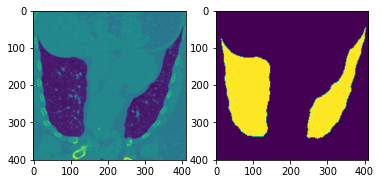

In [5]:
inspect_single_data_pair('SegmentationDataset', partition['train'], dataset='EMPIRE10', transform=transform)

In [6]:
# Generators
training_set = SegmentationDataset(partition['train'], dataset='EMPIRE10', transform=transform)
print(training_set)
batch_size=1
training_loader = DataLoader(training_set, batch_size=batch_size,
		                                shuffle=True, pin_memory=True)

In [47]:
# inspect model before training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

model = UNet().to(device)
#summary(model, (1, 256, 256))

In [48]:
x = next(iter(training_loader))

In [52]:
x[0].shape

torch.Size([1, 1, 256, 256])

In [54]:
#x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32).to(device)
#print()
with torch.no_grad():
    out = model(x[0].to(device))
print(out)

tensor([[[[ 0.6357, -1.8255, -0.3746,  ...,  1.1868,  1.0994, -3.0785],
          [ 0.6277,  0.1224, -1.6530,  ...,  1.5565,  0.8988,  0.8130],
          [-0.4170,  0.6666,  2.9042,  ...,  1.0904,  2.5925, -0.9383],
          ...,
          [ 0.0295, -1.7753,  0.3134,  ...,  3.1066,  2.5544,  2.7600],
          [ 0.5279,  0.5976,  0.9219,  ...,  1.8221,  2.7884,  4.3149],
          [ 1.1848,  1.7974,  2.5711,  ...,  0.7229,  1.5082, -0.2726]]]],
       device='cuda:0')
